### imports and Load Dataset

In [ ]:
import pyconll, nltk, datetime, warnings
from numpy.random import seed
# --- Imports ---
import os
from google import genai
from pydantic import BaseModel, Field
from typing import List, Literal, Optional, Tuple, Dict
import json
from enum import Enum
try:
    # Attempt to get API key from environment variable
    api_key = os.environ.get("GOOGLE_API_KEY")
    if not api_key:
        # Fallback or specific instruction for local setup
        # Replace with your actual key if needed, but environment variables are safer
        api_key = "YOUR_API_KEY"
        if api_key == "YOUR_API_KEY":
           print("⚠️ Warning: API key not found in environment variables. Using placeholder.")
           print("   Please set the GOOGLE_API_KEY environment variable or replace 'YOUR_API_KEY' in the code.")
except Exception as e:
    print(f"Error retrieving API key: {e}")

In [3]:
UD_ENGLISH_TRAIN = '../UD_English-EWT/en_ewt-ud-train.conllu'
UD_ENGLISH_DEV = '../UD_English-EWT/en_ewt-ud-dev.conllu'
UD_ENGLISH_TEST = '../UD_English-EWT/en_ewt-ud-test.conllu'

### Preprocessing

In [4]:
def read_conllu(path):
    data = pyconll.load_from_file(path)
    tagged_sentences=[]
    original_sentences=[]
    t=0
    for sentence in data:
        original_sentences.append(sentence.text)
        tagged_sentence=[]
        for token in sentence:
            if token.upos:
                t+=1
                tagged_sentence.append((token.form if token.form else '*None*', token.upos))
        tagged_sentences.append(tagged_sentence)
    return tagged_sentences, original_sentences

### Load train, development and test set in the appropriate tagged format, tuple (word, pos-tag)

In [7]:
train_sentences, train_original = read_conllu(UD_ENGLISH_TRAIN)
val_sentences, val_original = read_conllu(UD_ENGLISH_DEV)
test_sentences, test_original = read_conllu(UD_ENGLISH_TEST)

In [ ]:
print("Tagged sentences in test set: ", len(test_sentences))
print("Tagged words in test set:", len([item for sublist in test_sentences for item in sublist]))

Tagged sentences in test set:  2077
Tagged words in test set: 25096


In [ ]:
gemini_model = 'gemini-2.0-flash-lite'

# --- Define Pydantic Models for Structured Output ---

# --- Define the Universal Dependencies POS Tagset (17 core tags) as an enum ---
class UDPosTag(str, Enum):
    ADJ = "ADJ"      # adjective
    ADP = "ADP"      # adposition
    ADV = "ADV"      # adverb
    AUX = "AUX"      # auxiliary verb
    CCONJ = "CCONJ"  # coordinating conjunction
    DET = "DET"      # determiner
    INTJ = "INTJ"    # interjection
    NOUN = "NOUN"    # noun
    NUM = "NUM"      # numeral
    PART = "PART"    # particle
    PRON = "PRON"    # pronoun
    PROPN = "PROPN"  # proper noun
    PUNCT = "PUNCT"  # punctuation
    SCONJ = "SCONJ"  # subordinating conjunction
    SYM = "SYM"      # symbol
    VERB = "VERB"    # verb
    X = "X"          # other

class TokenPOS(BaseModel):
    text: str = Field(description="The token text.")
    pos_tag: UDPosTag = Field(description="The Universal Dependencies POS tag for the token.")

class SentencePOS(BaseModel):
    tokens: List[TokenPOS] = Field(description="A list of tokens with their POS tags for this sentence.")

class TaggedSentences(BaseModel):
    """Represents a list of sentences with their tagged tokens."""
    sentences: List[SentencePOS] = Field(description="A list of sentences, each containing tagged tokens.")


## 2.2 - Train methods
 

### Train method with original sentences

In [8]:
def tag_sentences_ud(text_to_tag: List[str]) -> Optional[TaggedSentences]:
    """
    Performs POS tagging on the input list of sentences using the Gemini API and
    returns the result structured according to the SentencePOS Pydantic model.

    Args:
        text_to_tag: A list of sentences to be POS tagged.

    Returns:
        A TaggedSentences object containing tagged tokens, or None if an error occurs.
    """
    prompt = f"""
You are a Universal Dependencies POS tagger.

Your task is to tag each sentence in the input list using the Universal Dependencies POS tagset (UD, 17 tags: ADJ, ADP, ADV, AUX, CCONJ, DET, INTJ, NOUN, NUM, PART, PRON, PROPN, PUNCT, SCONJ, SYM, VERB, X).
Also pay attention, that each one of the sentences provided, you need to keep it in the same order as you've got them, made sure you're getting X sentences, and return the same X sentences as output.
Return the result in **valid JSON format** using the following schema:

{{
  "sentences": [
    {{
      "tokens": [
        {{ "text": <token>, "pos_tag": <UD POS tag> }},
        ...
      ]
    }},
    ...
  ]
}}

Example input:
Sentence: The quick brown fox jumps over the lazy dog.
Sentence:  I love natural language processing!

Example output:
{{
  "sentences": [
    {{
      "tokens": [
        {{ "text": "The", "pos_tag": "DET" }},
        {{ "text": "quick", "pos_tag": "ADJ" }},
        {{ "text": "brown", "pos_tag": "ADJ" }},
        {{ "text": "fox", "pos_tag": "NOUN" }},
        {{ "text": "jumps", "pos_tag": "VERB" }},
        {{ "text": "over", "pos_tag": "ADP" }},
        {{ "text": "the", "pos_tag": "DET" }},
        {{ "text": "lazy", "pos_tag": "ADJ" }},
        {{ "text": "dog", "pos_tag": "NOUN" }},
        {{ "text": ".", "pos_tag": "PUNCT" }}
      ]
    }},
    {{
      "tokens": [
        {{ "text": "I", "pos_tag": "PRON" }},
        {{ "text": "love", "pos_tag": "VERB" }},
        {{ "text": "natural", "pos_tag": "ADJ" }},
        {{ "text": "language", "pos_tag": "NOUN" }},
        {{ "text": "processing", "pos_tag": "NOUN" }},
        {{ "text": "!", "pos_tag": "PUNCT" }}
      ]
    }}
  ]
}}

Now tag the following sentences:
{chr(10).join([f"{i+1}. {s}" for i, s in enumerate(text_to_tag)])}
"""


    client = genai.Client(api_key=api_key)
    response = client.models.generate_content(
        model=gemini_model,
        contents=prompt,
        config={
            'response_mime_type': 'application/json',
            'response_schema': TaggedSentences,
        },
    )
    print(response.text)
    res: TaggedSentences = response.parsed
    return res

### Train method with tokenized sentences

In [91]:

def tag_sentences_ud_tokenized(tokenized_sentences: List[List[Tuple[str, str]]]) -> Optional[TaggedSentences]:
    """
    Performs POS tagging on the input list of tokenized sentences (as lists of (word, tag) tuples)
    using the Gemini API and returns the result structured according to the SentencePOS Pydantic model.

    Args:
        tokenized_sentences: A list of sentences, each as a list of (word, tag) tuples.

    Returns:
        A TaggedSentences object containing tagged tokens, or None if an error occurs.
    """
    # Convert each sentence to a space-separated string of tokens
    sentences_as_strings = [" ".join([w for w, t in sent]) for sent in tokenized_sentences]

    prompt = f"""
You are a Universal Dependencies POS tagger.

Your task is to tag each sentence in the input list using the Universal Dependencies POS tagset (UD, 17 tags: ADJ, ADP, ADV, AUX, CCONJ, DET, INTJ, NOUN, NUM, PART, PRON, PROPN, PUNCT, SCONJ, SYM, VERB, X).
Also pay attention, that each one of the sentences provided, you need to keep it in the same order as you've got them.
Return the result in **valid JSON format** using the following schema:

{{
  "sentences": [
    {{
      "tokens": [
        {{ "text": <token>, "pos_tag": <UD POS tag> }},
        ...
      ]
    }},
    ...
  ]
}}

Example input:
Sentence: The quick brown fox jumps over the lazy dog.
Sentence: I love natural language processing!

Example output:
{{
  "sentences": [
    {{
      "tokens": [
        {{ "text": "The", "pos_tag": "DET" }},
        {{ "text": "quick", "pos_tag": "ADJ" }},
        {{ "text": "brown", "pos_tag": "ADJ" }},
        {{ "text": "fox", "pos_tag": "NOUN" }},
        {{ "text": "jumps", "pos_tag": "VERB" }},
        {{ "text": "over", "pos_tag": "ADP" }},
        {{ "text": "the", "pos_tag": "DET" }},
        {{ "text": "lazy", "pos_tag": "ADJ" }},
        {{ "text": "dog", "pos_tag": "NOUN" }},
        {{ "text": ".", "pos_tag": "PUNCT" }}
      ]
    }},
    {{
      "tokens": [
        {{ "text": "I", "pos_tag": "PRON" }},
        {{ "text": "love", "pos_tag": "VERB" }},
        {{ "text": "natural", "pos_tag": "ADJ" }},
        {{ "text": "language", "pos_tag": "NOUN" }},
        {{ "text": "processing", "pos_tag": "NOUN" }},
        {{ "text": "!", "pos_tag": "PUNCT" }}
      ]
    }}
  ]
}}

Now tag the following sentences:
{sentences_as_strings}
"""

    client = genai.Client(api_key=api_key)
    response = client.models.generate_content(
        model=gemini_model,
        contents=prompt,
        config={
            'response_mime_type': 'application/json',
            'response_schema': TaggedSentences,
        },
    )
    print(response.text)
    res: TaggedSentences = response.parsed
    return res

In [26]:
def tag_sequence(sentences):
    return [[t for w, t in sentence] for sentence in sentences]

def text_sequence(sentences):
    return [[w for w, t in sentence] for sentence in sentences]

def id2word(sentences):
    wordlist = [item for sublist in text_sequence(sentences) for item in sublist]
    id2word = {k:v for k,v in enumerate(wordlist)}
    return id2word

def untag(tagged_sentence):
    return [w for w, _ in tagged_sentence]

def untag_pos(tagged_sentence):
    return [t for _, t in tagged_sentence]

def build_vocab(sentences):
    vocab =set()
    for sentence in sentences:
        for word in untag(sentence):
            vocab.add(word)
    return sorted(list(vocab))

### Convertion methods utils

In [169]:
def convert_fixed_to_tagged_sentences(fixed_data):
    """Convert the fixed format back to TaggedSentences format using the proper classes"""
    tagged_sentences = []
    
    for item in fixed_data:
        sentence = item["sentence"]
        predictions = item["predictions"]
        
        # Create tokens with POS tags using TokenPOS class
        tokens = []
        for word, pos_tag in zip(sentence.split(), predictions):
            # Create TokenPOS object
            token = TokenPOS(text=word, pos_tag=pos_tag)
            tokens.append(token)
        
        # Create SentencePOS object
        sentence_obj = SentencePOS(tokens=tokens)
        tagged_sentences.append(sentence_obj)
    
    # Create TaggedSentences object
    tagged_sentences_obj = TaggedSentences(sentences=tagged_sentences)
    
    return tagged_sentences_obj



In [ ]:
def collect_hard_sentences_from_llm(
    predicted: TaggedSentences,
    ground_truth: List[List[Tuple[str, str]]],
    test_original
) -> List[Dict]:
    """
    Collect sentences with errors and format them to match hard_sentences.json structure.
    
    Returns:
        List of dictionaries with format: {"sentence": str, "errors": int, "predictions": List[str]}
    """
    hard_sentences = []
    
    for pred_sent_obj, gold_sentence, org_sentence in zip(predicted.sentences, ground_truth, test_original):
        # Extract predictions as list of POS tags
        pred_tags = [token.pos_tag.value for token in pred_sent_obj.tokens]
        
        # Count errors by comparing with gold standard
        errors = sum(1 for (gold_word, gold_tag), pred_tag in zip(gold_sentence, pred_tags) 
                    if gold_tag != pred_tag)
        
        if errors > 0 and errors <= 3:
            
            # Format to match hard_sentences.json structure
            hard_sentences.append({
                "sentence": org_sentence,
                "errors": errors,
                "predictions": pred_tags
            })
    
    print(f"\nNumber of sentences with errors: {len(hard_sentences)} out of {len(ground_truth)}")
    return hard_sentences

### Run the LLM tagger on the tokenized sentences

In [85]:
import json
from typing import List

# 1. Run the LLM tagger on the tokenized sentences
BATCH_SIZE = 15
llm_tagged_tokenized = []

for i in range(0, len(test_sentences), BATCH_SIZE):
    batch = test_sentences[i:i+BATCH_SIZE]
    tagged_result = tag_sentences_ud_tokenized(batch)
    if tagged_result and tagged_result.sentences:
        llm_tagged_tokenized.extend(tagged_result.sentences)
    else:
        print(f"⚠️ Skipping batch {i//BATCH_SIZE + 1} due to tagging failure.")


{
  "sentences": [
    {
      "tokens": [
        { "text": "What", "pos_tag": "DET" },
        { "text": "if", "pos_tag": "SCONJ" },
        { "text": "Google", "pos_tag": "PROPN" },
        { "text": "Morphed", "pos_tag": "VERB" },
        { "text": "Into", "pos_tag": "ADP" },
        { "text": "GoogleOS", "pos_tag": "PROPN" },
        { "text": "?", "pos_tag": "PUNCT" }
      ]
    },
    {
      "tokens": [
        { "text": "What", "pos_tag": "DET" },
        { "text": "if", "pos_tag": "SCONJ" },
        { "text": "Google", "pos_tag": "PROPN" },
        { "text": "expanded", "pos_tag": "VERB" },
        { "text": "on", "pos_tag": "ADP" },
        { "text": "its", "pos_tag": "PRON" },
        { "text": "search", "pos_tag": "NOUN" },
        { "text":  "-", "pos_tag": "PUNCT" },
        { "text": "engine", "pos_tag": "NOUN" },
        { "text": "(", "pos_tag": "PUNCT" },
        { "text": "and", "pos_tag": "CCONJ" },
        { "text": "now", "pos_tag": "ADV" },
        { "text": "e

In [138]:
# Wrap all collected SentencePOS objects into one TaggedSentences object
merged_result_tokenized = TaggedSentences(sentences=llm_tagged_tokenized)


In [111]:
import json

# Convert merged_result_tokenized (TaggedSentences) to a serializable format
merged_sentences_tokenized_json = []
for sent_obj in merged_result_tokenized.sentences:
    tokens = [
        {
            "text": token.text,
            "pos_tag": token.pos_tag.value if hasattr(token.pos_tag, "value") else str(token.pos_tag)
        }
        for token in sent_obj.tokens
    ]
    merged_sentences_tokenized_json.append({"tokens": tokens})

with open("merged_sentences_tokenized.json", "w", encoding="utf-8") as f:
    json.dump(merged_sentences_tokenized_json, f, indent=2, ensure_ascii=False)

print("merged_result_tokenized exported to merged_sentences_tokenized.json")

merged_result_tokenized exported to merged_sentences_tokenized.json


In [92]:
# Fixed version to match the desired format
fixed_merged_sentences_tokenized = []

for sentence_idx in range(len(merged_result_tokenized.sentences)):
    # Extract the predicted POS tags from the merged result
    predicted_tags = [token.pos_tag.value for token in merged_result_tokenized.sentences[sentence_idx].tokens]
    
    fixed_merged_sentences_tokenized.append({
        "sentence": test_original[sentence_idx],
        # "tokenized_sentence": test_sentences[sentence_idx],
        "predictions": predicted_tags
    })



In [ ]:
# Now you can use it with the collect_hard_sentences_from_llm method
converted_predicted_tokenized = convert_fixed_to_tagged_sentences(fixed_merged_sentences_tokenized)

hard_sentences_tokenized = collect_hard_sentences_from_llm(converted_predicted_tokenized, test_sentences, test_original)


In [95]:
# After the existing code that saves to hard_sentences.json, add this:
with open("hard_tokenized_sentences_llm.json", "w", encoding="utf-8") as f:
    json.dump(hard_sentences_tokenized, f, indent=4, ensure_ascii=False)

print(f"Hard sentences also exported to hard_tokenized_sentences_llm.json")

Hard sentences also exported to hard_tokenized_sentences_llm.json


### Load the predictions from json file

In [ ]:
import json

# Load sentences from both files
with open("merged_sentences.json", "r", encoding="utf-8") as f1:
    all_sentences_dicts = json.load(f1)

# Convert dicts to SentencePOS objects
all_sentences = [SentencePOS(**s) for s in all_sentences_dicts]

# Create a TaggedSentences object
merged_result = TaggedSentences(sentences=all_sentences)

# Fixed version to match the desired format
fixed_merged_sentences = []

for sentence_idx in range(len(merged_result.sentences)):
    # Extract the predicted POS tags from the merged result
    predicted_tags = [token.pos_tag.value for token in merged_result.sentences[sentence_idx].tokens]
    
    fixed_merged_sentences.append({
        "sentence": test_original[sentence_idx],
        "predictions": predicted_tags
    })

### Load hard sentences from exisiting file

In [28]:
import json

with open("hard_sentences_tokenized.json", "r", encoding="utf-8") as f:
    hard_sentences_tokenized = json.load(f)

print(f"Loaded {len(hard_sentences_tokenized)} hard sentences from hard_sentences_tokenized.json")

Loaded 770 hard sentences from hard_sentences_llm.json


### 2.2.1 - Token analysis

In [174]:
# First, let's compute accuracy and F1 scores for the LLM tagger
def compute_llm_tagger_metrics(predicted_tags: TaggedSentences) -> Tuple[float, float, List[str], List[str]]:
    """
    Compute token-level metrics for the LLM tagger
    """
    total_tokens = 0
    correct_predictions = 0
    all_gold_tags = []
    all_predicted_tags = []
    
    for i, (pred_sent_obj, gold_sentence) in enumerate(zip(predicted_tags.sentences, test_sentences)):
        # Extract predictions as list of POS tags
        pred_tags = [token.pos_tag.value for token in pred_sent_obj.tokens]
        
        # Extract gold tags
        gold_tags = [tag for _, tag in gold_sentence]
        
        # Count correct predictions
        for pred_tag, gold_tag in zip(pred_tags, gold_tags):
            total_tokens += 1
            if pred_tag == gold_tag:
                correct_predictions += 1
            
            all_gold_tags.append(gold_tag)
            all_predicted_tags.append(pred_tag)
    
    accuracy = correct_predictions / total_tokens if total_tokens > 0 else 0
    
    # Calculate F1 score
    from sklearn.metrics import f1_score
    f1_macro = f1_score(all_gold_tags, all_predicted_tags, average='macro', zero_division=1)
    
    print(f"LLM Tagger Token-Level Metrics:")
    print(f"Total tokens: {total_tokens}")
    print(f"Correct predictions: {correct_predictions}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-macro score: {f1_macro:.4f}")
    
    return accuracy, f1_macro, all_gold_tags, all_predicted_tags

# Compute metrics
llm_accuracy, llm_f1, all_gold_tags, all_predicted_tags = compute_llm_tagger_metrics(converted_predicted_tokenized)


LLM Tagger Token-Level Metrics:
Total tokens: 13471
Correct predictions: 1989
Accuracy: 0.1477
F1-macro score: 0.1099


In [98]:
def token_misclassified_llm(predicted: TaggedSentences, ground_truth: List[List[Tuple[str, str]]]):
    """
    Given a list of tagged sentences, return a dictionary mapping tokens to the number of times they were misclassified.
    """
    from collections import Counter
    token_errors = Counter()

    for pred_sent_obj, gold_sentence in zip(predicted.sentences, ground_truth):
        # Extract predictions as list of POS tags
        pred_tags = [token.pos_tag.value for token in pred_sent_obj.tokens]
        
        # Extract gold tags and words
        gold_tags = [tag for _, tag in gold_sentence]
        gold_words = [word for word, _ in gold_sentence]

        for i, (pred_tag, gold_tag, gold_word) in enumerate(zip(pred_tags, gold_tags, gold_words)):
            if pred_tag != gold_tag:
                token_errors[gold_word] += 1

    return token_errors

# Get token errors for LLM tagger
llm_token_errors = token_misclassified_llm(converted_predicted_tokenized, test_sentences)


In [ ]:
# Print tokens misclassified more than 10 times
print("\n=== Tokens misclassified more than 10 times by LLM Tagger ===")
for token, count in llm_token_errors.items():
    if count > 10:
        print(f'Token: {token}, Misclassified {count} times')


=== Tokens misclassified more than 10 times by LLM Tagger ===
Token: (, Misclassified 13 times
Token: and, Misclassified 68 times
Token: ), Misclassified 16 times
Token: when, Misclassified 24 times
Token: all, Misclassified 13 times
Token: that, Misclassified 91 times
Token: this, Misclassified 39 times
Token: out, Misclassified 20 times
Token: has, Misclassified 14 times
Token: a, Misclassified 48 times
Token: on, Misclassified 37 times
Token: what, Misclassified 12 times
Token: was, Misclassified 19 times
Token: for, Misclassified 54 times
Token: one, Misclassified 13 times
Token: my, Misclassified 23 times
Token: not, Misclassified 31 times
Token: -, Misclassified 99 times
Token: of, Misclassified 54 times
Token: your, Misclassified 28 times
Token: ,, Misclassified 109 times
Token: you, Misclassified 22 times
Token: do, Misclassified 13 times
Token: to, Misclassified 70 times
Token: with, Misclassified 23 times
Token: it, Misclassified 22 times
Token: is, Misclassified 25 times
To

In [99]:
# Find sentences containing frequently misclassified tokens
def find_sentences_with_frequent_errors(predicted: TaggedSentences, ground_truth: List[List[Tuple[str, str]]], 
                                      test_original: List[str], threshold: int = 10):
    """
    Find sentences containing tokens that are misclassified more than threshold times
    """
    from collections import Counter
    token_errors = Counter()
    sentences_with_errors = []

    for pred_sent_obj, gold_sentence, org_sentence in zip(predicted.sentences, ground_truth, test_original):
        # Extract predictions as list of POS tags
        pred_tags = [token.pos_tag.value for token in pred_sent_obj.tokens]
        
        # Extract gold tags and words
        gold_tags = [tag for _, tag in gold_sentence]
        gold_words = [word for word, _ in gold_sentence]

        for i, (pred_tag, gold_tag, gold_word) in enumerate(zip(pred_tags, gold_tags, gold_words)):
            if pred_tag != gold_tag:
                token_errors[gold_word] += 1
                if token_errors[gold_word] > threshold:
                    sentences_with_errors.append(org_sentence)

    return token_errors, sentences_with_errors

# Find sentences with frequent errors
llm_token_errors_detailed, llm_misclassified_sentences = find_sentences_with_frequent_errors(
    converted_predicted_tokenized, test_sentences, test_original, threshold=10
)

Error Analysis for LLM Tagger 

1. **Context Window Limitations**: LLMs may have limited context understanding for complex syntactic structures.
2. **Training Data Mismatch**: The LLM may not have been specifically trained on UD POS tagging.
3. **Ambiguity Resolution**: Some tokens may have multiple possible tags depending on context.
4. **Domain Knowledge**: Technical or domain-specific vocabulary may be challenging.
5. **Prompt Engineering**: The quality of the prompt may affect tagging accuracy.


In [100]:
print(f'\n=== Sentences with frequently misclassified tokens (LLM Tagger) ===')
print(f'Number of sentences with frequently misclassified tokens: {len(set(llm_misclassified_sentences))}')

# Show some examples of sentences with frequent errors
print("\nExample sentences with frequently misclassified tokens:")
for i, sentence in enumerate(list(set(llm_misclassified_sentences))[:10]):  # Show first 10
    print(f"{i+1}. {sentence}")


=== Sentences with frequently misclassified tokens (LLM Tagger) ===
Number of sentences with frequently misclassified tokens: 1357

Example sentences with frequently misclassified tokens:
1. i didn't want you to go.
2. Arriving in Auckland on a direct flight from Canada.?
3. You should really ask this in the art section.
4. The thing about The Script is they do not sound that Irish, I was surprised to hear they were from Dublin.
5. I'm going on a vacation to the Philippines in May 2012, and I'm starting from Raleigh, NC (RDU Airport).
6. Great food and nice people very pleasant experience.
7. I Highly Recommend, The Law Offices Of Dale Gribow!!
8. Job Title: Attorney
9. Farrell Electric is a very good electrical contractor.
10. Name something you find at a carnival that comes on a stick?


In [101]:
hard_examples_llm = [
    "The lead singer decided to lead the group to success.",  # Ambiguous "lead"
    "She re-read the book to re-evaluate her understanding.",  # Hyphenated words
    "The server threw a 404 error when the API endpoint was hit.",  # Technical jargon
    "Although the cat, which had been missing for days, finally returned, it seemed uninterested in food.",  # Complex structure
    "The present company will present the present to the present audience."  # Multiple meanings of "present"
]

print("\nHard examples designed to challenge the LLM tagger:")
for i, example in enumerate(hard_examples_llm, 1):
    print(f"{i}. {example}")

print("\nMethod to create these hard examples:")
print("- **Ambiguity**: Use words with multiple meanings in the same sentence")
print("- **Technical Terms**: Include domain-specific vocabulary not in general training data")
print("- **Complex Syntax**: Create sentences with nested clauses and long dependencies")
print("- **Hyphenation**: Use compound words that may not be well-represented")
print("- **Multiple Ambiguous Words**: Combine several challenging elements in one sentence")

# Test the hard examples with the LLM tagger
print("\n=== Testing Hard Examples with LLM Tagger ===")

def test_hard_examples_with_llm(examples: List[str]):
    """
    Test the hard examples with the LLM tagger
    """
    results = []
    
    for example in examples:
        try:
            # Tag the sentence using the LLM
            tagged_result = tag_sentences_ud([example])
            
            if tagged_result and tagged_result.sentences:
                # Extract the predictions
                pred_tags = [token.pos_tag.value for token in tagged_result.sentences[0].tokens]
                results.append({
                    "sentence": example,
                    "predictions": pred_tags,
                    "tokens": example.split()
                })
            else:
                results.append({
                    "sentence": example,
                    "predictions": [],
                    "tokens": example.split(),
                    "error": "Tagging failed"
                })
        except Exception as e:
            results.append({
                "sentence": example,
                "predictions": [],
                "tokens": example.split(),
                "error": str(e)
            })
    
    return results

# Test the hard examples
hard_example_results = test_hard_examples_with_llm(hard_examples_llm)



Hard examples designed to challenge the LLM tagger:
1. The lead singer decided to lead the group to success.
2. She re-read the book to re-evaluate her understanding.
3. The server threw a 404 error when the API endpoint was hit.
4. Although the cat, which had been missing for days, finally returned, it seemed uninterested in food.
5. The present company will present the present to the present audience.

Method to create these hard examples:
- **Ambiguity**: Use words with multiple meanings in the same sentence
- **Technical Terms**: Include domain-specific vocabulary not in general training data
- **Complex Syntax**: Create sentences with nested clauses and long dependencies
- **Hyphenation**: Use compound words that may not be well-represented
- **Multiple Ambiguous Words**: Combine several challenging elements in one sentence

=== Testing Hard Examples with LLM Tagger ===
{
  "sentences": [
    {
      "tokens": [
        { "text": "The", "pos_tag": "DET" },
        { "text": "lead

In [106]:
print("\nResults of testing hard examples:")
for result in hard_example_results:
    print(f"\nSentence: {result['sentence']}")
    if 'error' in result:
        print(f"Error: {result['error']}")
    else:
        print(f"Predictions: {list(zip(result['tokens'], result['predictions']))}")

# Summary of token analysis
print("\n=== Summary of Token Analysis ===")
print(f"LLM Tagger Performance:")
print(f"- Overall Accuracy: {llm_accuracy:.4f}")
print(f"- F1-Macro Score: {llm_f1:.4f}")
print(f"- Total tokens analyzed: {len(all_gold_tags)}")
print(f"- Tokens with errors: {len(all_gold_tags) - sum(1 for p, g in zip(all_predicted_tags, all_gold_tags) if p == g)}")

print(f"\nError Analysis:")
print(f"- Tokens misclassified >10 times: {len([t for t, c in llm_token_errors.items() if c > 10])}")
print(f"- Most common misclassified token: {max(llm_token_errors.items(), key=lambda x: x[1]) if llm_token_errors else 'None'}")

print(f"\nHard Examples Created: {len(hard_examples_llm)}")
print("These examples are designed to test the LLM tagger's ability to handle:")
print("- Ambiguous words with multiple meanings")
print("- Technical and domain-specific vocabulary")
print("- Complex syntactic structures")
print("- Compound and hyphenated words")
print("- Context-dependent tagging decisions")


Results of testing hard examples:

Sentence: The lead singer decided to lead the group to success.
Predictions: [('The', 'DET'), ('lead', 'NOUN'), ('singer', 'NOUN'), ('decided', 'VERB'), ('to', 'PART'), ('lead', 'VERB'), ('the', 'DET'), ('group', 'NOUN'), ('to', 'ADP'), ('success.', 'NOUN')]

Sentence: She re-read the book to re-evaluate her understanding.
Predictions: [('She', 'PRON'), ('re-read', 'VERB'), ('the', 'DET'), ('book', 'NOUN'), ('to', 'PART'), ('re-evaluate', 'VERB'), ('her', 'PRON'), ('understanding.', 'NOUN')]

Sentence: The server threw a 404 error when the API endpoint was hit.
Predictions: [('The', 'DET'), ('server', 'NOUN'), ('threw', 'VERB'), ('a', 'DET'), ('404', 'NUM'), ('error', 'NOUN'), ('when', 'SCONJ'), ('the', 'DET'), ('API', 'NOUN'), ('endpoint', 'NOUN'), ('was', 'AUX'), ('hit.', 'VERB')]

Sentence: Although the cat, which had been missing for days, finally returned, it seemed uninterested in food.
Predictions: [('Although', 'SCONJ'), ('the', 'DET'), ('cat

### 2.2.2+3 - Comprasions between LLM to LR taggers' errors


In [107]:
def analyze_tagger_comparison():
    """
    Analyze the comparison between Logistic Regression Tagger and LLM Tagger
    to answer the two questions about error patterns.
    """
    
    # Load the data
    with open("hard_sentences.json", "r", encoding="utf-8") as f:
        lr_hard_sentences = json.load(f)
    
    with open("hard_tokenized_sentences_llm.json", "r", encoding="utf-8") as f:
        llm_hard_sentences = json.load(f)
    
    # Create lookup dictionaries for quick access
    lr_sentence_to_data = {}
    for item in lr_hard_sentences:
        sentence = item["sentence"]
        lr_sentence_to_data[sentence] = {
            "gt_sentence": item["gt_sentence"],
            "errors": item["errors"],
            "predictions": item["predictions"]
        }
    
    llm_sentence_to_data = {}
    for item in llm_hard_sentences:
        sentence = item["sentence"]
        llm_sentence_to_data[sentence] = {
            "errors": item["errors"],
            "predictions": item["predictions"]
        }
    
    # Initialize counters
    lr_errors_fixed_by_llm = 0
    llm_new_errors = 0
    
    # Analyze each sentence that appears in both datasets
    for sentence in lr_sentence_to_data.keys():
        if sentence in llm_sentence_to_data:
            # Find the index in test_original
            try:
                sentence_idx = test_original.index(sentence)
                gt_sentence = test_sentences[sentence_idx]  # Get ground truth from test_sentences
                
                # Extract gold tags
                gold_tags = [tag for _, tag in gt_sentence]
                
                # Get predictions from both taggers
                lr_pred_tags = lr_sentence_to_data[sentence]["predictions"]
                llm_pred_tags = llm_sentence_to_data[sentence]["predictions"]
                
                # Count errors for each tagger
                lr_errors = sum(1 for p, g in zip(lr_pred_tags, gold_tags) if p != g)
                llm_errors = sum(1 for p, g in zip(llm_pred_tags, gold_tags) if p != g)
                
                # Question 1: How many LR errors are fixed by LLM?
                if lr_errors > 0 and llm_errors < lr_errors:
                    lr_errors_fixed_by_llm += (lr_errors - llm_errors)
                
                # Question 2: How many new errors does LLM make that LR didn't?
                # Find positions where LLM made errors but LR was correct
                for i, (lr_pred, llm_pred, gold) in enumerate(zip(lr_pred_tags, llm_pred_tags, gold_tags)):
                    if llm_pred != gold and lr_pred == gold:
                        llm_new_errors += 1
                        
            except ValueError:
                # Sentence not found in test_original (shouldn't happen but just in case)
                continue
    
    # Print results
    print("=== Tagger Comparison Analysis ===")
    print(f"1. Logistic Regression errors fixed by LLM Tagger: {lr_errors_fixed_by_llm}")
    print(f"2. New errors made by LLM Tagger (not made by LR): {llm_new_errors}")
    
    return lr_errors_fixed_by_llm, llm_new_errors

# Run the analysis
lr_fixed, llm_new = analyze_tagger_comparison()

# Additional detailed analysis
def detailed_error_analysis():
    """
    Provide more detailed analysis of the error patterns
    """
    print("\n=== Detailed Error Analysis ===")
    
    # Load data again for detailed analysis
    with open("hard_sentences.json", "r", encoding="utf-8") as f:
        lr_hard_sentences = json.load(f)
    
    with open("hard_sentences_llm.json", "r", encoding="utf-8") as f:
        llm_hard_sentences = json.load(f)
    
    # Count total sentences and errors
    total_lr_sentences = len(lr_hard_sentences)
    total_llm_sentences = len(llm_hard_sentences)
    
    total_lr_errors = sum(item["errors"] for item in lr_hard_sentences)
    total_llm_errors = sum(item["errors"] for item in llm_hard_sentences)
    
    print(f"Total sentences with errors:")
    print(f"  - Logistic Regression: {total_lr_sentences}")
    print(f"  - LLM Tagger: {total_llm_sentences}")
    
    print(f"\nTotal errors:")
    print(f"  - Logistic Regression: {total_lr_errors}")
    print(f"  - LLM Tagger: {total_llm_errors}")
    
    # Calculate improvement percentage
    if total_lr_errors > 0:
        improvement = ((total_lr_errors - total_llm_errors) / total_lr_errors) * 100
        print(f"\nOverall improvement: {improvement:.2f}%")

# Run detailed analysis
detailed_error_analysis()

=== Tagger Comparison Analysis ===
1. Logistic Regression errors fixed by LLM Tagger: 78
2. New errors made by LLM Tagger (not made by LR): 382

=== Detailed Error Analysis ===
Total sentences with errors:
  - Logistic Regression: 804
  - LLM Tagger: 770

Total errors:
  - Logistic Regression: 1381
  - LLM Tagger: 1143

Overall improvement: 17.23%


### 2.2.4 - Comprasions between LLM to LR taggers' errors

Below are explanations generated by the LLM for a subset of sentences where the LLM tagger made errors. For each, we show the sentence, the LLM's predictions, the gold tags, and the LLM's explanation for its mistakes.

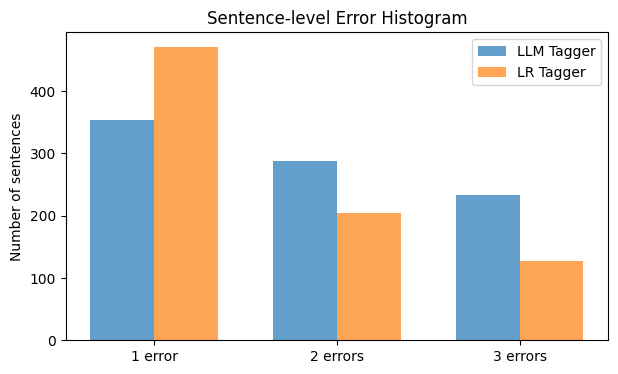

In [103]:
# Sentence-level error histograms for LLM and LR taggers
import json
import matplotlib.pyplot as plt
from collections import Counter

# Load hard sentence data
with open("hard_tokenized_sentences_llm.json", "r", encoding="utf-8") as f:
    llm_hard = json.load(f)
with open("hard_sentences.json", "r", encoding="utf-8") as f:
    lr_hard = json.load(f)

# Count errors per sentence
llm_error_counts = Counter(item['errors'] for item in llm_hard)
lr_error_counts = Counter(item['errors'] for item in lr_hard)

# Prepare bins (1,2,3)
bins = [1,2,3]
llm_hist = [llm_error_counts.get(b,0) for b in bins[:-1]]
llm_hist.append(sum(v for k,v in llm_error_counts.items() if k>=bins[-1]))
lr_hist = [lr_error_counts.get(b,0) for b in bins[:-1]]
lr_hist.append(sum(v for k,v in lr_error_counts.items() if k>=bins[-1]))

# Plot
labels = ['1 error','2 errors','3 errors']
x = range(len(labels))
plt.figure(figsize=(7,4))
plt.bar(x, llm_hist, width=0.35, label='LLM Tagger', alpha=0.7)
plt.bar([i+0.35 for i in x], lr_hist, width=0.35, label='LR Tagger', alpha=0.7)
plt.xticks([i+0.175 for i in x], labels)
plt.ylabel('Number of sentences')
plt.title('Sentence-level Error Histogram')
plt.legend()
plt.show()

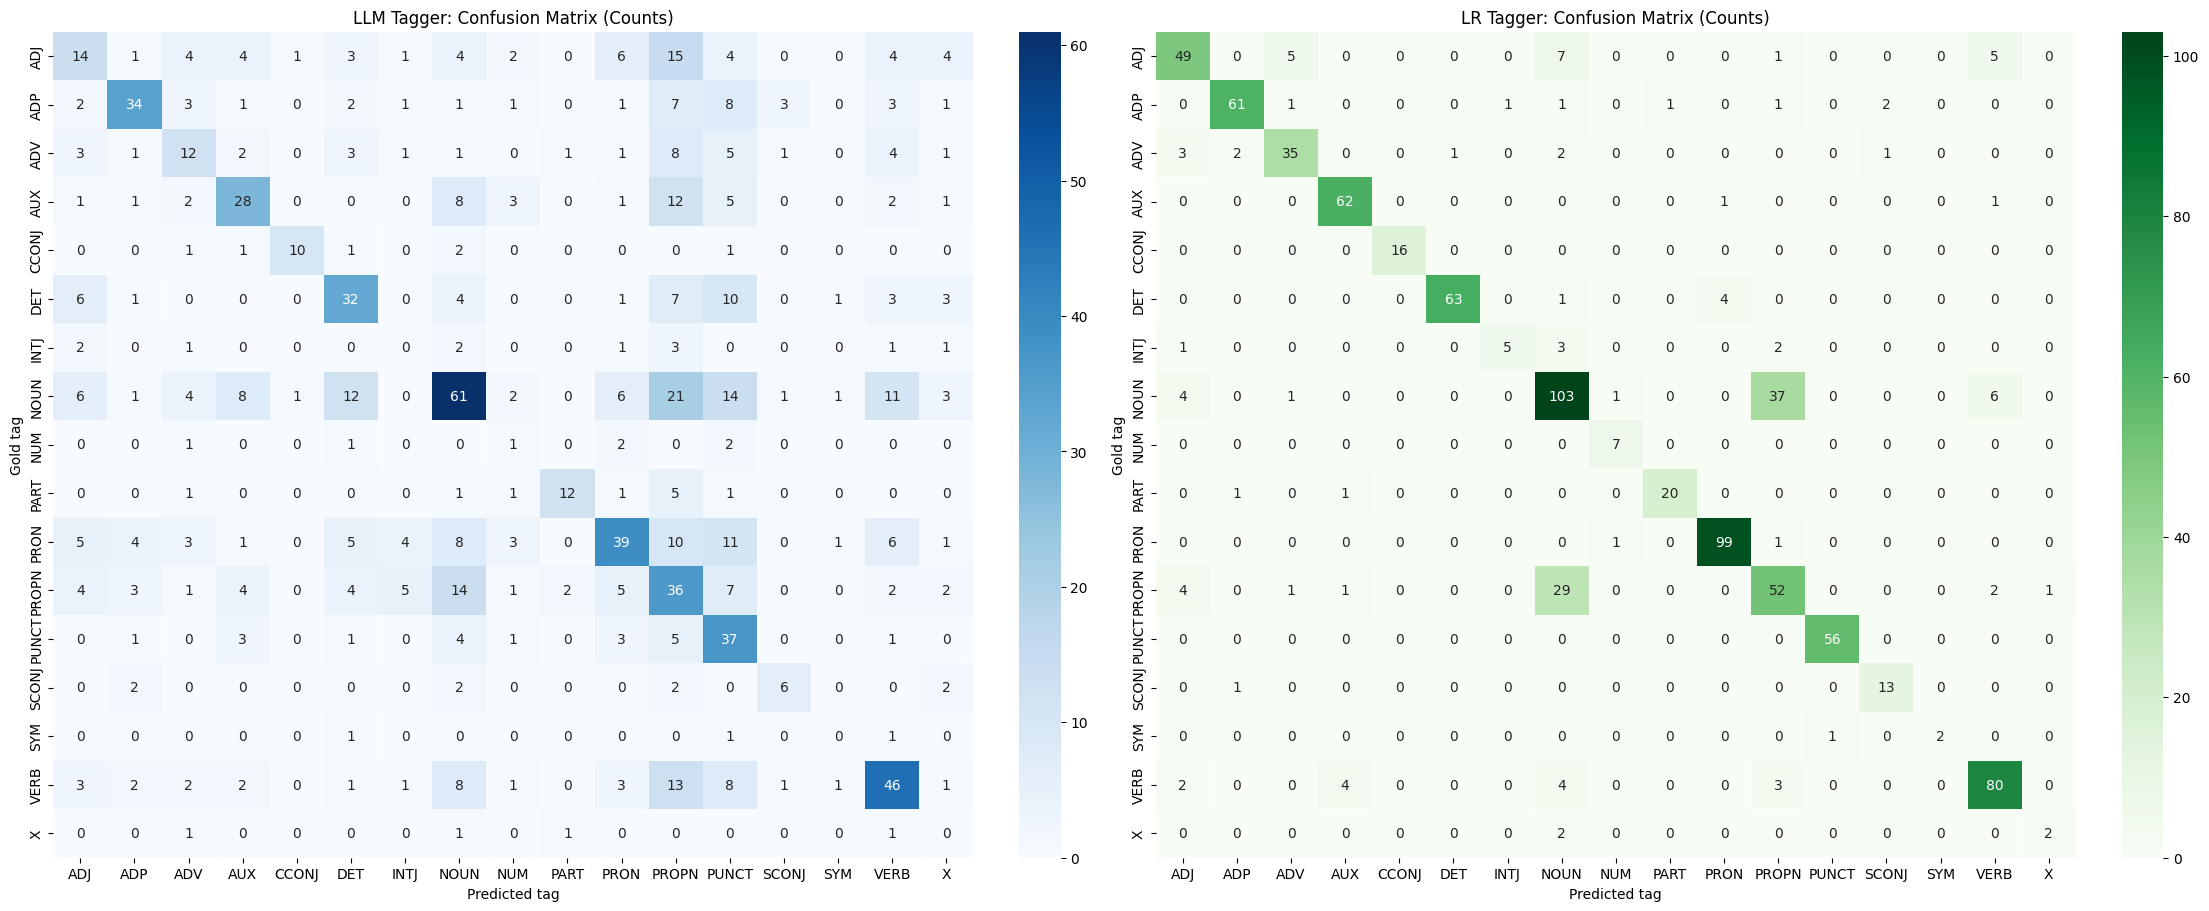

Top confusions per tag (counts) - LLM:
  ADJ → [('PROPN', 15), ('PRON', 6), ('X', 4), ('VERB', 4), ('PUNCT', 4)]
  ADP → [('PUNCT', 8), ('PROPN', 7), ('ADV', 3), ('SCONJ', 3), ('VERB', 3)]
  NOUN → [('PROPN', 21), ('PUNCT', 14), ('DET', 12), ('VERB', 11), ('AUX', 8)]
  VERB → [('PROPN', 13), ('NOUN', 8), ('PUNCT', 8), ('ADJ', 3), ('PRON', 3)]
  PROPN → [('NOUN', 14), ('PUNCT', 7), ('INTJ', 5), ('PRON', 5), ('AUX', 4)]
  ADV → [('PROPN', 8), ('PUNCT', 5), ('VERB', 4), ('ADJ', 3), ('DET', 3)]
  PRON → [('PUNCT', 11), ('PROPN', 10), ('NOUN', 8), ('VERB', 6), ('DET', 5)]
  AUX → [('PROPN', 12), ('NOUN', 8), ('PUNCT', 5), ('NUM', 3), ('ADV', 2)]
  DET → [('PUNCT', 10), ('PROPN', 7), ('ADJ', 6), ('NOUN', 4), ('X', 3)]
  CCONJ → [('NOUN', 2), ('AUX', 1), ('PUNCT', 1), ('DET', 1), ('ADV', 1)]
  SCONJ → [('X', 2), ('PROPN', 2), ('NOUN', 2), ('ADP', 2)]
  NUM → [('PUNCT', 2), ('PRON', 2), ('ADV', 1), ('DET', 1)]
  PART → [('PROPN', 5), ('ADV', 1), ('PUNCT', 1), ('PRON', 1), ('NUM', 1)]
  PUNCT →

In [10]:
# POS Confusion Matrices (Gold vs Predicted) for LLM and LR taggers
# - Expects:
#   - test_original, test_sentences already loaded (UD test set)
#   - hard_sentences.json (LR "hard sentences" with predictions)
#   - hard_tokenized_sentences_llm.json (LLM "hard sentences" with predictions)

import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# --- Sanity: ensure gold data exists in scope ---
if 'test_original' not in globals() or 'test_sentences' not in globals():
    raise RuntimeError("Missing gold data: please ensure 'test_original' and 'test_sentences' are defined (loaded from UD).")

# --- Load hard sentences for both taggers ---
with open("hard_sentences.json", "r", encoding="utf-8") as f:
    lr_hard_sentences = json.load(f)

with open("hard_tokenized_sentences_llm.json", "r", encoding="utf-8") as f:
    llm_hard_sentences = json.load(f)

# --- Build sentence -> data maps (predictions, errors) ---
lr_sentence_to_data = {}
for item in lr_hard_sentences:
    sentence = item["sentence"]
    lr_sentence_to_data[sentence] = {
        "predictions": item["predictions"],
        "errors": item.get("errors", None),
    }

llm_sentence_to_data = {}
for item in llm_hard_sentences:
    sentence = item["sentence"]
    llm_sentence_to_data[sentence] = {
        "predictions": item["predictions"],
        "errors": item.get("errors", None),
    }

# --- Map original sentence -> gold POS tags ---
orig_to_gold_tags = {}
for sent_text, gold_sent in zip(test_original, test_sentences):
    orig_to_gold_tags[sent_text] = [tag for _, tag in gold_sent]

# --- Collect flattened gold/predictions for common sentences ---
gold_all, llm_all, lr_all = [], [], []
common_sents = set(lr_sentence_to_data.keys()).intersection(llm_sentence_to_data.keys())

for sent in common_sents:
    gold_tags = orig_to_gold_tags.get(sent)
    if not gold_tags:
        continue
    lr_pred = lr_sentence_to_data[sent]["predictions"]
    llm_pred = llm_sentence_to_data[sent]["predictions"]

    n = min(len(gold_tags), len(lr_pred), len(llm_pred))
    if n <= 0:
        continue

    gold_all.extend(gold_tags[:n])
    lr_all.extend(lr_pred[:n])
    llm_all.extend(llm_pred[:n])

if not gold_all:
    raise RuntimeError("No overlapping tokens found between LR/LLM hard sentences and gold data.")

# --- Define labels and compute confusion matrices (rows: gold, cols: predicted) ---
labels = sorted(list(set(gold_all) | set(llm_all) | set(lr_all)))

cm_llm = confusion_matrix(gold_all, llm_all, labels=labels)
cm_lr  = confusion_matrix(gold_all, lr_all,  labels=labels)

# Normalize row-wise (per gold tag)
cm_llm_norm = cm_llm.astype(float) / np.maximum(cm_llm.sum(axis=1, keepdims=True), 1)
cm_lr_norm  = cm_lr.astype(float)  / np.maximum(cm_lr.sum(axis=1, keepdims=True), 1)

# --- Plot side-by-side heatmaps ---
fig, axes = plt.subplots(1, 2, figsize=(22, 9), constrained_layout=True)

sns.heatmap(cm_llm, ax=axes[0], xticklabels=labels, yticklabels=labels,
            cmap="Blues", annot=True, fmt="d", cbar=True)
axes[0].set_title("LLM Tagger: Confusion Matrix (Counts)")
axes[0].set_xlabel("Predicted tag")
axes[0].set_ylabel("Gold tag")

sns.heatmap(cm_lr, ax=axes[1], xticklabels=labels, yticklabels=labels,
            cmap="Greens", annot=True, fmt="d", cbar=True)
axes[1].set_title("LR Tagger: Confusion Matrix (Counts)")
axes[1].set_xlabel("Predicted tag")
axes[1].set_ylabel("Gold tag")

plt.show()

# --- Optional: top confusions for key tags (counts, not normalized) ---
focus = ["ADJ", "ADP", "NOUN", "VERB", "PROPN", "ADV", "PRON", "AUX", "DET", "CCONJ", "SCONJ", "NUM", "PART", "PUNCT"]
focus = [t for t in focus if t in labels]
idx = {t:i for i,t in enumerate(labels)}

def top_confusions(cm, tag, k=5):
    i = idx[tag]
    row = cm[i].copy()
    row[i] = 0  # ignore correct
    if row.sum() == 0:
        return []
    order = np.argsort(row)[::-1]
    return [(labels[j], int(cm[i, j])) for j in order[:k] if cm[i, j] > 0]

print("Top confusions per tag (counts) - LLM:")
for t in focus:
    tc = top_confusions(cm_llm, t, k=5)
    if tc:
        print(f"  {t} → {tc}")

print("\nTop confusions per tag (counts) - LR:")
for t in focus:
    tc = top_confusions(cm_lr, t, k=5)
    if tc:
        print(f"  {t} → {tc}")

### 2.2.5 Hypotheses: What makes sentences difficult for the LLM Tagger?


- **Ambiguity:** Sentences with words that have multiple possible POS tags depending on context (e.g., "lead", "present").
- **Complex Syntax:** Sentences with nested clauses, long dependencies, or unusual word order.
- **Domain-specific Vocabulary:** Technical or rare words not seen in training data.
- **Punctuation and Hyphenation:** Sentences with unusual punctuation or compound/hyphenated words.
- **Short/Fragmented Sentences:** Lack of context can make tagging harder.

#### New challenging sentences for the LLM Tagger:
1. "After the update, the server refused to update the update log."
2. "Flying planes can be dangerous, especially when flying low."
3. "The bass was painted on the bass drum."
4. "He will record a new record for the record label."
5. "The complex houses married and single soldiers and their families."

These sentences are designed to include ambiguity, complex structure, and context-dependent tagging.

### 2.3 Error Explanation and Synthetic Data

In [104]:
import random

# Select a random sample of hard sentences with errors
sampled = random.sample(hard_sentences_tokenized, min(5, len(hard_sentences_tokenized)))
sampled_sentences = []
def get_gold_tags(sentence_text):
    # Find the index in test_original and get gold tags
    try:
        idx = test_original.index(sentence_text)
        return [tag for _, tag in test_sentences[idx]]
    except Exception:
        return []

for item in sampled:
    sentence = item["sentence"]
    sampled_sentences.append(sentence)
    predictions = item["predictions"]
    gold_tags = get_gold_tags(sentence)
    print(f"Sentence: {sentence}")
    print(f"Gold tags:      {gold_tags}\n")
    

Sentence: Horrible!
Gold tags:      ['ADJ', 'PUNCT']

Sentence: I'm not driving tonite, but I bet that we could hitch a ride back with Anil.
Gold tags:      ['PRON', 'AUX', 'PART', 'VERB', 'NOUN', 'PUNCT', 'CCONJ', 'PRON', 'VERB', 'SCONJ', 'PRON', 'AUX', 'VERB', 'DET', 'NOUN', 'ADV', 'ADP', 'PROPN', 'PUNCT']

Sentence: I was married by a judge.
Gold tags:      ['PRON', 'AUX', 'VERB', 'ADP', 'DET', 'NOUN', 'PUNCT']

Sentence: This is a great place to get a permit
Gold tags:      ['PRON', 'AUX', 'DET', 'ADJ', 'NOUN', 'PART', 'VERB', 'DET', 'NOUN']

Sentence: What if Google Morphed Into GoogleOS?
Gold tags:      ['PRON', 'SCONJ', 'PROPN', 'VERB', 'ADP', 'PROPN', 'PUNCT']



### 2.3.1+2 - Collect LLM explanations for a random sample of hard sentences and extract error categories


In [ ]:
import re
def get_llm_explanation_json(sentence, predictions, gold_tags):
    """
    Call the LLM to explain its errors for the given sentence.
    Returns a JSON array of error objects.
    """
    prompt = f"""
Given the following sentence and POS tagging results, for each token where the predicted tag differs from the gold tag, output a JSON object with:
- word: the token
- correct_tag: the gold POS tag
- predicted_tag: the LLM's predicted POS tag
- explanation: a brief explanation of the error
- category: a short error category (e.g., "Ambiguity", "Punctuation vs Symbol", etc.)

Return a JSON array of such objects.

Sentence: {sentence}
LLM POS tags: {predictions}
Gold POS tags: {gold_tags}

Example output:
[
  {{
    "word": "ONLINE",
    "correct_tag": "ADJ",
    "predicted_tag": "NOUN",
    "explanation": "The word 'ONLINE' is often used ....",
    "category": "Ambiguity (ADJ/NOUN)"
  }},
  {{
    "word": "-",
    "correct_tag": "SYM",
    "predicted_tag": "PUNCT",
    "explanation": "The hyphen in 'September 16 - 18' functions ...",
    "category": "Punctuation vs Symbol"
  }}
]
Now, output the JSON for the errors in the sentence above.
"""
    client = genai.Client(api_key=api_key)
    response = client.models.generate_content(
        model=gemini_model,
        contents=prompt,
        config={
            'response_mime_type': 'application/json',
        },
    )
    return response.text  # or response.parsed if using a schema

error_categories = set()
explanations = []

for item in sampled:
    sentence = item["sentence"]
    predictions = item["predictions"]
    gold_tags = get_gold_tags(sentence)
    explanation_json = get_llm_explanation_json(sentence, predictions, gold_tags)
    explanations.append({
        "sentence": sentence,
        "explanation": explanation_json
    })
    # Parse the explanation JSON and collect categories
    try:
        errors = json.loads(explanation_json)
        for err in errors:
            if "category" in err:
                error_categories.add(err["category"])
    except Exception as e:
        print(f"Failed to parse explanation for sentence: {sentence}\nError: {e}")

print("\nLLM Explanations for Sampled Errors:")
for ex in explanations:
    print(f"Sentence: {ex['sentence']}")
    print(f"Explanation: {ex['explanation']}\n")

print("Collected error categories:")
for cat in sorted(error_categories):
    print("-", cat)



LLM Explanations for Sampled Errors:
Sentence: Horrible!
Explanation: [
  {
    "word": "Horrible",
    "correct_tag": "ADJ",
    "predicted_tag": "DET",
    "explanation": "The word 'Horrible' is an adjective describing the sentence, but the LLM incorrectly tagged it as a determiner.",
    "category": "Incorrect Part-of-Speech"
  },
  {
    "word": "!",
    "correct_tag": "PUNCT",
    "predicted_tag": "DET",
    "explanation": "The exclamation mark is a punctuation mark, but the LLM incorrectly tagged it as a determiner.",
    "category": "Incorrect Part-of-Speech"
  }
]

Sentence: I'm not driving tonite, but I bet that we could hitch a ride back with Anil.
Explanation: [
  {
    "word": "I'm",
    "correct_tag": "PRON",
    "predicted_tag": "X",
    "explanation": "The model fails to recognize this as a pronoun, likely due to the contraction.",
    "category": "Contraction"
  },
  {
    "word": "not",
    "correct_tag": "PART",
    "predicted_tag": "X",
    "explanation": "The model

## Section 3: Dealing with Segmentation - Mission 1

### Test the performance of the LLM tagger on the original sentences
In the previous evaluation, the LLM tagger was tested on pre-segmented (CoNLL-tokenized) sentences. In this section, we will evaluate the LLM tagger on the original, unsegmented sentences from the UD English EWT dataset.

**Steps:**
1. Run the LLM tagger on the original sentences (from `test_original`).
2. Compare the predictions to the gold standard (CoNLL-tokenized and tagged).
3. Compute token-level and sentence-level metrics (accuracy, F1, error histograms).
4. Collect sentences that fail with the original sentences but succeeded with the tokenized version.
5. Discuss whether evaluation metrics need to be updated for this new setting.

The following code cell implements this evaluation.

## 3.1 - Test the performance of the LLM tagger on the original sentences (not pre-segmented)


In [ ]:
import json
from typing import List

# 1. Run the LLM tagger on the original sentences
BATCH_SIZE = 15
original_sentences = test_original
llm_tagged_original = []

for i in range(0, len(original_sentences), BATCH_SIZE):
    batch = original_sentences[i:i+BATCH_SIZE]
    tagged_result = tag_sentences_ud(batch)
    if tagged_result and tagged_result.sentences:
        llm_tagged_original.extend(tagged_result.sentences)
    else:
        print(f"⚠️ Skipping batch {i//BATCH_SIZE + 1} due to tagging failure.")

{
  "sentences": [
    {
      "tokens": [
        { "text": "What", "pos_tag": "DET" },
        { "text": "if", "pos_tag": "SCONJ" },
        { "text": "Google", "pos_tag": "PROPN" },
        { "text": "Morphed", "pos_tag": "VERB" },
        { "text": "Into", "pos_tag": "ADP" },
        { "text": "GoogleOS", "pos_tag": "PROPN" },
        { "text": "?", "pos_tag": "PUNCT" }
      ]
    },
    {
      "tokens": [
        { "text": "What", "pos_tag": "DET" },
        { "text": "if", "pos_tag": "SCONJ" },
        { "text": "Google", "pos_tag": "PROPN" },
        { "text": "expanded", "pos_tag": "VERB" },
        { "text": "on", "pos_tag": "ADP" },
        { "text": "its", "pos_tag": "PRON" },
        { "text": "search-engine", "pos_tag": "NOUN" },
        { "text": "(", "pos_tag": "PUNCT" },
        { "text": "and", "pos_tag": "CCONJ" },
        { "text": "now", "pos_tag": "ADV" },
        { "text": "e-mail", "pos_tag": "NOUN" },
        { "text": ")", "pos_tag": "PUNCT" },
        { "tex

In [160]:
# Wrap all collected SentencePOS objects into one TaggedSentences object
merged_result_original = TaggedSentences(sentences=llm_tagged_original)

In [161]:
merged_sentences_on_original_sentences = []

for sent_obj in merged_result_original.sentences:
    tokens = [
        {
            "text": token.text,
            "pos_tag": token.pos_tag.value if hasattr(token.pos_tag, "value") else str(token.pos_tag)
        }
        for token in sent_obj.tokens
    ]
    merged_sentences_on_original_sentences.append({"tokens": tokens})

with open("merged_sentences_on_original_sentences.json", "w", encoding="utf-8") as f:
    json.dump(merged_sentences_on_original_sentences, f, indent=2, ensure_ascii=False)

In [165]:
with open("merged_sentences_on_original_sentences.json", "r", encoding="utf-8") as f:
    merged_sentences_on_original_sentences = json.load(f)

In [171]:
merged_result_original = TaggedSentences(sentences=merged_sentences_on_original_sentences)

fixed_merged_sentences = []

for sentence_idx in range(len(merged_result_original.sentences)):
    # Extract the predicted POS tags from the merged result
    predicted_tags = [token.pos_tag.value for token in merged_result_original.sentences[sentence_idx].tokens]
    
    fixed_merged_sentences_tokenized.append({
        "sentence": test_original[sentence_idx],
        # "tokenized_sentence": test_sentences[sentence_idx],
        "predictions": predicted_tags
    })

converted_predicted = convert_fixed_to_tagged_sentences(fixed_merged_sentences_tokenized)

hard_sentences = collect_hard_sentences_from_llm(converted_predicted, test_sentences, test_original)


Number of sentences with errors: 875 out of 2077


In [172]:
with open("hard_sentences_llm.json", "w", encoding="utf-8") as f:
    json.dump(hard_sentences, f, indent=4, ensure_ascii=False)

print(f"Hard sentences also exported to hard_sentences_llm.json")

Hard sentences also exported to hard_sentences_llm.json


### Load hard sentences from exisiting file


In [108]:
import json

with open("hard_sentences_llm.json", "r", encoding="utf-8") as f:
    hard_sentences = json.load(f)

print(f"Loaded {len(hard_sentences)} hard sentences from hard_sentences_llm.json")

Loaded 770 hard sentences from hard_sentences_llm.json


In [179]:
llm_accuracy, llm_f1, all_gold_tags, all_predicted_tags = compute_llm_tagger_metrics(converted_predicted)


LLM Tagger Token-Level Metrics:
Total tokens: 13471
Correct predictions: 1989
Accuracy: 0.1477
F1-macro score: 0.1099


### Collect sentences that fail with original but succeeded with tokenized version


In [ ]:
def extract_pred_tags(sent_obj):
    # Handles both dict and SentencePOS object
    if hasattr(sent_obj, "tokens"):
        # sent_obj is likely a SentencePOS or similar object
        return [
            token.pos_tag.value if hasattr(token.pos_tag, "value") else str(token.pos_tag)
            for token in sent_obj.tokens
        ]
    elif isinstance(sent_obj, dict) and "tokens" in sent_obj:
        # sent_obj is a dict from JSON
        return [
            token["pos_tag"] if isinstance(token, dict) and "pos_tag" in token else str(token)
            for token in sent_obj["tokens"]
        ]
    else:
        raise ValueError("Unknown sentence object type")

llm_original_pred_tags = [extract_pred_tags(s) for s in merged_result_original.sentences]
llm_tokenized_pred_tags = [extract_pred_tags(s) for s in converted_predicted.sentences]
gold_tags_list = [[tag for _, tag in sent] for sent in test_sentences]

failed_sentences = []
for idx, (pred_orig, gold, pred_tok) in enumerate(zip(llm_original_pred_tags, gold_tags_list, llm_tokenized_pred_tags)):
    min_len = min(len(pred_orig), len(gold), len(pred_tok))
    errors_orig = sum(p != g for p, g in zip(pred_orig[:min_len], gold[:min_len]))
    errors_tok = sum(p != g for p, g in zip(pred_tok[:min_len], gold[:min_len]))
    if errors_orig > 0 and errors_tok == 0:
        failed_sentences.append({
            "sentence": original_sentences[idx],
            "errors_original": errors_orig,
            "errors_tokenized": errors_tok,
            "gold": gold[:min_len],
            "pred_original": pred_orig[:min_len],
            "pred_tokenized": pred_tok[:min_len]
        })

print(f"\nSentences that failed with original but succeeded with tokenized version: {len(failed_sentences)}")
for ex in failed_sentences[:5]:
    print(f"\nSentence: {ex['sentence']}")
    print(f"Errors (original): {ex['errors_original']}, Errors (tokenized): {ex['errors_tokenized']}")
    print(f"Gold: {ex['gold']}")
    print(f"Pred (original): {ex['pred_original']}")


Sentences that failed with original but succeeded with tokenized version: 6

Sentence: One of the pictures shows a flag that was found in Fallujah.
Errors (original): 1, Errors (tokenized): 0
Gold: ['NUM', 'ADP', 'DET', 'NOUN', 'VERB', 'DET', 'NOUN', 'PRON', 'AUX', 'VERB', 'ADP', 'PROPN']
Pred (original): ['NUM', 'ADP', 'DET', 'NOUN', 'VERB', 'DET', 'NOUN', 'DET', 'AUX', 'VERB', 'ADP', 'PROPN']

Sentence: Let me join the chorus of annoyance over Google's new toolbar , which, as noted in the linked article, commits just about every sin an online marketer could commit, and makes up a few new ones besides.
Errors (original): 27, Errors (tokenized): 0
Gold: ['VERB', 'PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'PROPN', 'PART', 'ADJ', 'NOUN', 'PUNCT', 'PRON', 'PUNCT', 'SCONJ', 'VERB', 'ADP', 'DET', 'VERB', 'NOUN', 'PUNCT', 'VERB', 'ADV', 'ADV', 'DET', 'NOUN', 'DET', 'ADJ', 'NOUN', 'AUX', 'VERB', 'PUNCT', 'CCONJ', 'VERB', 'ADP', 'DET']
Pred (original): ['VERB', 'PRON', 'VERB', 'DET'

## 3.2 - Evaluation Metrics and Few-Shot Prompting for LLM Segmenter

This section defines evaluation metrics for segmentation and demonstrates how to use a few-shot prompting strategy for the LLM segmenter. The evaluation is performed on the set of sentences where tagging failed in the previous evaluation.

In [11]:
# --- Extract 3 few-shot segmentation examples from the UD data ---

import random

# Use train set for diversity, but you can use test or val as well
few_shot_examples = []
used_indices = set()
max_examples = 3

while len(few_shot_examples) < max_examples:
    idx = random.randint(0, len(train_sentences) - 1)
    if idx in used_indices:
        continue
    used_indices.add(idx)
    orig = train_original[idx]
    gold_tokens = [w for w, _ in train_sentences[idx]]
    # Skip if original is empty or already used
    if not orig or not gold_tokens:
        continue
    few_shot_examples.append({
        "input": orig,
        "output": gold_tokens
    })

# Print the few-shot examples for inspection
for i, ex in enumerate(few_shot_examples, 1):
    print(f"Example {i}:")
    print("Original:", ex["input"])
    print("Segmented:", ex["output"])
    print()

# Now you can use `few_shot_examples` in your LLM segmenter prompt construction

Example 1:
Original: I'm quite sure , you don't even have to buy another , all you need to do , is to pour some oil on the wheel , or even put some rubber on it's edges , the part that is making the noise .
Segmented: ['I', "'m", 'quite', 'sure', ',', 'you', 'do', "n't", 'even', 'have', 'to', 'buy', 'another', ',', 'all', 'you', 'need', 'to', 'do', ',', 'is', 'to', 'pour', 'some', 'oil', 'on', 'the', 'wheel', ',', 'or', 'even', 'put', 'some', 'rubber', 'on', "it's", 'edges', ',', 'the', 'part', 'that', 'is', 'making', 'the', 'noise', '.']

Example 2:
Original: from start to finish they were top notch.
Segmented: ['from', 'start', 'to', 'finish', 'they', 'were', 'top', 'notch', '.']

Example 3:
Original: China has its own reserves of oil and natural gas and once was a net oil exporter.
Segmented: ['China', 'has', 'its', 'own', 'reserves', 'of', 'oil', 'and', 'natural', 'gas', 'and', 'once', 'was', 'a', 'net', 'oil', 'exporter', '.']



In [12]:
# System prompt for the LLM (improved for UD possessive clitics and clarity)
system_prompt = (
    "You are an expert in English word segmentation and tokenization. "
    "Given an original sentence, return a JSON list of tokens according to the Universal Dependencies (UD) English guidelines: "
    "- Words are generally delimited by whitespace or punctuation. No token should contain whitespace. "
    "- Use multiword tokens for English clitics (e.g., 'll, 'm, 's, 've, 'd, n't). For example, don't = do + n't. "
    "- Possessive clitics ('s, ') must always be separated from the base word. For example, \"John's\" → [\"John\", \"'s\"], \"dogs'\" → [\"dogs\", \"'\"] "
    "- Most hyphenated terms are split (e.g., search-engine becomes search, -, engine). "
    "- Do not split acronyms (e.g., FBI, U.S.) or abbreviations without spaces (e.g., i.e.). "
    "- Some hyphenated words with common prefixes/suffixes (e.g., e-mail, co-ordinated) are not split. "
    "- Ensure no token contains whitespace. "
    "Do not perform any POS tagging, only segmentation. Output only a JSON list of tokens."
)


### Pipeline vs. Joint Tagging Comparison
- **Pipeline**: Segment with LLM, then POS tag segmented output.
- **Joint**: LLM segments and tags in one step (returns list of (token, POS) pairs).
- Compare both on hard sentences and report metrics.

## Improved LLM Segmenter and Evaluation Plan
This section implements:
- Batch LLM segmentation for failed sentences using few-shot prompting (CoNLL/UD style).
- Aggregation and evaluation of segmentation results (precision, recall, F1).
- Pipeline vs. joint segmentation+tagging comparison on hard sentences.

In [18]:

import json
from typing import List, Dict
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
import time
BATCH_SIZE = 10  # Tune as needed for LLM limits

def build_few_shot_prompt(examples, sentences):
    
    user = "Here are some examples:\n"
    for ex in examples:
        user += f'Original: {ex["input"]}\nSegmented: {json.dumps(ex["output"])}\n'
    user += "\nSegment these sentences (return a JSON list for each, in order):\n"
    for s in sentences:
        user += f'Original: {s}\nSegmented: '
    return system_prompt, user
def call_llm_segmenter(system_prompt_combined, user_prompt, model=gemini_model, api_key=None):
    client = genai.Client(api_key=api_key)
    prompt = f"{system_prompt_combined}\n\n{user_prompt}"
    response = client.models.generate_content(
        model=model,
        contents=prompt,
        config={
            'response_mime_type': 'application/json',
        },
    )
    return response.text
def parse_llm_segmenter_output(output, num_sentences):
    # Try to parse a list of lists from the LLM output
    try:
        parsed = json.loads(output)
        if isinstance(parsed, list) and all(isinstance(x, list) for x in parsed) and len(parsed) == num_sentences:
            return parsed
        # Sometimes LLM returns a dict with keys
        if isinstance(parsed, dict):
            return [parsed.get(str(i), []) for i in range(num_sentences)]
    except Exception as e:
        print("Parse error:", e)
    return [[] for _ in range(num_sentences)]
def evaluate_segmentation(gold: List[List[str]], pred: List[List[str]]):
    gold_flat = [tok for sent in gold for tok in sent]
    pred_flat = [tok for sent in pred for tok in sent]
    # Simple token-level metrics
    correct = sum(g==p for g, p in zip(gold_flat, pred_flat))
    precision = correct / len(pred_flat) if pred_flat else 0
    recall = correct / len(gold_flat) if gold_flat else 0
    f1 = 2*precision*recall/(precision+recall) if (precision+recall)>0 else 0
    return precision, recall, f1


In [14]:
with open("hard_sentences_llm.json", encoding="utf-8") as f:
    hard_data = json.load(f)

In [ ]:
# 1. Load your current hard data
with open('hard_sentences_llm.json', 'r', encoding='utf-8') as f:
    hard_data = json.load(f)

# 2. Use the test data you already have loaded
# test_sentences and test_original contain the gold standard

# 3. For each sentence in hard_data, find it in test_original and add gold_tokens
enhanced_data = []
for hard_sentence in hard_data:
    sentence_text = hard_sentence['sentence']
    
    # Find matching sentence in test_original by comparing the full sentence text
    for i, original_sentence in enumerate(test_original):
        # Compare directly with the original sentence text
        if sentence_text == original_sentence:
            # Add gold_tokens to the structure using the corresponding test_sentences
            enhanced_sentence = hard_sentence.copy()
            enhanced_sentence['gold_tokens'] = test_sentences[i]  # This gives you [(token, pos_tag), ...]
            enhanced_data.append(enhanced_sentence)
            break

# 4. Save the enhanced data
with open('hard_sentences_llm_with_gold_tokens.json', 'w', encoding='utf-8') as f:
    json.dump(enhanced_data, f, indent=2)

print(f"Found matches for {len(enhanced_data)} out of {len(hard_data)} sentences")

Found matches for 875 out of 875 sentences


In [ ]:
# Use enhanced_data that now has gold_tokens
failed_sentences = [x["sentence"] for x in enhanced_data]
gold_segmented = [x.get("gold_tokens") or [] for x in enhanced_data]

# Extract just the tokens from gold_tokens (remove POS tags)
gold_tokens_only = []
for sentence_tokens in gold_segmented:
    if sentence_tokens:
        # Extract just the token text from [token, pos_tag] tuples
        tokens_only = [token[0] for token in sentence_tokens]
        gold_tokens_only.append(tokens_only)
    else:
        gold_tokens_only.append([])

all_preds = []

# Process in batches
for i in range(0, len(failed_sentences), BATCH_SIZE):
    batch = failed_sentences[i:i+BATCH_SIZE]  # Fixed: use proper batch slicing
    system, user = build_few_shot_prompt(few_shot_examples, batch)
    output = call_llm_segmenter(system, user, api_key=api_key)
    batch_preds = parse_llm_segmenter_output(output, len(batch))
    all_preds.extend(batch_preds)
    time.sleep(1)  # Avoid rate limits

# Evaluate segmentation if gold available
if any(gold_tokens_only):
    prec, rec, f1 = evaluate_segmentation(gold_tokens_only, all_preds)
    print(f"LLM Segmenter: Precision={prec:.3f}, Recall={rec:.3f}, F1={f1:.3f}")
    
    # Print detailed comparison for first few sentences
    print("\nDetailed comparison (first 3 sentences):")
    for i in range(min(3, len(gold_tokens_only), len(all_preds))):
        print(f"\nSentence {i+1}:")
        print(f"Original: {failed_sentences[i]}")
        print(f"Gold tokens: {gold_tokens_only[i]}")
        print(f"LLM tokens: {all_preds[i]}")
        
        # Check if they match
        if gold_tokens_only[i] == all_preds[i]:
            print("✅ Perfect match!")
        else:
            print("❌ Mismatch")
            
            # Find differences
            gold_set = set(gold_tokens_only[i])
            llm_set = set(all_preds[i])
            
            missing_in_llm = gold_set - llm_set
            extra_in_llm = llm_set - gold_set
            
            if missing_in_llm:
                print(f"  Missing in LLM: {missing_in_llm}")
            if extra_in_llm:
                print(f"  Extra in LLM: {extra_in_llm}")
else:
    print("No gold segmentation available for evaluation.")

# Save the results to a JSON file
import json
from datetime import datetime

# Create results data structure
segmentation_results = []
for i in range(len(failed_sentences)):
    if i < len(gold_tokens_only) and i < len(all_preds):
        result = {
            "sentence": failed_sentences[i],
            "gold_tokens": gold_tokens_only[i],
            "predicted_tokens": all_preds[i],
            "is_perfect_match": gold_tokens_only[i] == all_preds[i],
            "metrics": {}
        }
        
        # Calculate sentence-level metrics
        if gold_tokens_only[i] and all_preds[i]:
            gold_set = set(gold_tokens_only[i])
            pred_set = set(all_preds[i])
            
            correct = len(gold_set.intersection(pred_set))
            total_gold = len(gold_tokens_only[i])
            total_pred = len(all_preds[i])
            
            sent_precision = correct / total_pred if total_pred > 0 else 0.0
            sent_recall = correct / total_gold if total_gold > 0 else 0.0
            sent_f1 = 2 * (sent_precision * sent_recall) / (sent_precision + sent_recall) if (sent_precision + sent_recall) > 0 else 0.0
            
            result["metrics"] = {
                "precision": sent_precision,
                "recall": sent_recall,
                "f1": sent_f1,
                "correct_tokens": correct,
                "total_gold": total_gold,
                "total_predicted": total_pred
            }
            
            # Add detailed differences
            missing_in_llm = list(gold_set - pred_set)
            extra_in_llm = list(pred_set - gold_set)
            
            result["differences"] = {
                "missing_in_llm": missing_in_llm,
                "extra_in_llm": extra_in_llm,
                "missing_count": len(missing_in_llm),
                "extra_count": len(extra_in_llm)
            }
        
        segmentation_results.append(result)

# Save to file with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"segmentation_results_{timestamp}.json"

with open(filename, 'w', encoding='utf-8') as f:
    json.dump({
        "metadata": {
            "timestamp": timestamp,
            "total_sentences": len(segmentation_results),
            "overall_metrics": {
                "precision": prec,
                "recall": rec,
                "f1": f1
            },
            "batch_size": BATCH_SIZE,
            "model_info": "LLM Segmenter with few-shot prompting"
        },
        "results": segmentation_results
    }, f, indent=2, ensure_ascii=False)

print(f"\nResults saved to: {filename}")
print(f"Total sentences processed: {len(segmentation_results)}")
print(f"Perfect matches: {sum(1 for r in segmentation_results if r['is_perfect_match'])}")
print(f"Sentences with errors: {sum(1 for r in segmentation_results if not r['is_perfect_match'])}")


In [6]:
import json

with open("segmentation_results_20250831_204349.json", "r", encoding="utf-8") as f:
    data = json.load(f)

total_correct = 0
total_gold = 0
total_predicted = 0

for entry in data["results"]:
    metrics = entry.get("metrics", {})
    if "correct_tokens" in metrics and "total_gold" in metrics and "total_predicted" in metrics:
        total_correct += metrics["correct_tokens"]
        total_gold += metrics["total_gold"]
        total_predicted += metrics["total_predicted"]

precision = total_correct / total_predicted if total_predicted > 0 else 0
recall = total_correct / total_gold if total_gold > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

segmentation_results = data["results"]

print(f"Total sentences processed: {len(segmentation_results)}")
print(f"Perfect matches: {sum(1 for r in segmentation_results if r.get('is_perfect_match'))}")
print(f"Sentences with errors: {sum(1 for r in segmentation_results if not r.get('is_perfect_match'))}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1: {f1:.4f}")

Total sentences processed: 875
Perfect matches: 711
Sentences with errors: 164
Precision: 0.9122
Recall: 0.9048
F1: 0.9085
